# Transfer Learning

In [62]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing import image
import sklearn.model_selection
import matplotlib.pyplot as plt

## Load dataset meta file

In [105]:
df = pd.read_csv("data/seeds-microscope.txt")
df

,path,label,y
0,../plant-images-dataset/seeds-microscope/Ochra...,ochradenus,7
1,../plant-images-dataset/seeds-microscope/Ochra...,ochradenus,7
2,../plant-images-dataset/seeds-microscope/Ochra...,ochradenus,7
3,../plant-images-dataset/seeds-microscope/Ochra...,ochradenus,7
4,../plant-images-dataset/seeds-microscope/Ochra...,ochradenus,7
...,...,...,...
133,../plant-images-dataset/seeds-microscope/Tamer...,tamerix,11
134,../plant-images-dataset/seeds-microscope/Tamer...,tamerix,11
135,../plant-images-dataset/seeds-microscope/Tamer...,tamerix,11
136,../plant-images-dataset/seeds-microscope/Tamer...,tamerix,11


In [106]:
print("Number of species: %d" % len(set(df['label'])))

Number of species: 12


In [107]:
df = df.sample(frac=1)

## Plot some examples

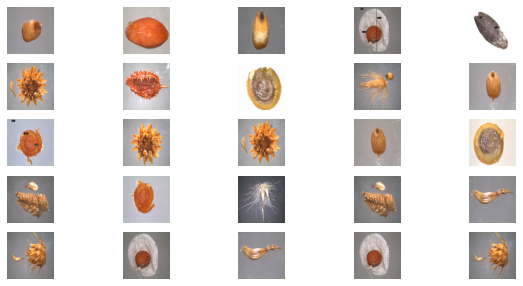

In [108]:
f, axes = plt.subplots(5, 5, figsize=(10, 5))
axes = axes.flatten()

for i in range(25):
    img = image.load_img(df.iloc[i]['path'], target_size=(224,224))
    axes[i].imshow(img)
    axes[i].axis('off')

## Extract image features using a pre-trained NN model

In [109]:
import tensorflow.keras.applications.mobilenet_v2

# load MobileNet V2 model which is available in tensorflow
model = tensorflow.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet', 
        include_top=False, 
        pooling='max')

In [111]:
images = []
for r in df.itertuples():
    img = image.load_img(r.path, target_size=(224,224))
    
    # convert to numpy array
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    # execute preprocessing actions needed by the model
    # for mobilenet this scales the input pixel values between -1 and 1
    x = tensorflow.keras.applications.mobilenet_v2.preprocess_input(x)
    
    #print("Finished %s" % r.path)
    
    # add processed image
    images.append(x)
    
# extract features
features = model.predict(np.vstack(images), batch_size=32)
print(features.shape)
np.save("data/seeds-microscope", features)

(138, 1280)


## Split the data into training and testing

In [112]:
X = features
y = np.array(df['y'])
Y = tf.keras.utils.to_categorical(y)

Xtrain, Xtest, Ytrain, Ytest = sklearn.model_selection.train_test_split(X, Y, stratify=y, test_size=0.2, random_state=41)
print(np.sum(Ytrain, axis=0))
print(np.sum(Ytest, axis=0))
print("Training instances: %d, testing: %d" % (Xtrain.shape[0], Xtest.shape[0]))

mu = np.mean(Xtrain, axis=0)
std = np.std(Xtrain, axis=0)

Xtrain = (Xtrain - mu)/std
Xtest = (Xtest - mu)/std

[12.  6. 10.  6.  5. 15.  5.  6. 18. 15.  7.  5.]
[3. 1. 3. 1. 1. 4. 1. 2. 5. 4. 2. 1.]
Training instances: 110, testing: 28


## Train a simple model to classify images using extracted features

In [113]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(input_shape=(Xtrain.shape[1],)),
        tf.keras.layers.Dense(Ytrain.shape[1], activation="softmax"),
    ]
)
model.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 12)                15372     
Total params: 15,372
Trainable params: 15,372
Non-trainable params: 0
_________________________________________________________________


In [114]:
h = model.fit(Xtrain, Ytrain, verbose=True, epochs=100)

Epoch 1/100
4/4 [==============================] - 0s 2ms/step - loss: 2.9781 - accuracy: 0.1182
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 1.8935 - accuracy: 0.3727
Epoch 3/100
4/4 [==============================] - 0s 751us/step - loss: 1.1589 - accuracy: 0.6818
Epoch 4/100
4/4 [==============================] - 0s 998us/step - loss: 0.6574 - accuracy: 0.9000
Epoch 5/100
4/4 [==============================] - 0s 752us/step - loss: 0.3830 - accuracy: 0.9636
Epoch 6/100
4/4 [==============================] - 0s 750us/step - loss: 0.2309 - accuracy: 0.9818
Epoch 7/100
4/4 [==============================] - 0s 1000us/step - loss: 0.1485 - accuracy: 1.0000
Epoch 8/100
4/4 [==============================] - 0s 750us/step - loss: 0.0997 - accuracy: 1.0000
Epoch 9/100
4/4 [==============================] - 0s 999us/step - loss: 0.0728 - accuracy: 1.0000
Epoch 10/100
4/4 [==============================] - 0s 750us/step - loss: 0.0558 - accuracy: 1.0000
Epoch 11/100

## Evaluate test performance

In [115]:
Ypred = model.predict(Xtest)

In [116]:
Ypred_hard = np.argmax(Ypred, axis=1)
Ytest_class = np.argmax(Ytest, axis=1)

cm = sklearn.metrics.confusion_matrix(Ytest_class, Ypred_hard)
acc = sklearn.metrics.balanced_accuracy_score(Ytest_class, Ypred_hard)

print("Balanced accuracy: %0.2f" % acc)
print("Confusion matrix:")

cm = cm / np.sum(cm, axis=1, keepdims=True)
with np.printoptions(precision=2, suppress=True):
    print(cm)

Balanced accuracy: 0.93
Confusion matrix:
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.33 0.   0.67 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.   0.   0.   0.5  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
